In [1]:
library(ComplexHeatmap)
library(patchwork)
library(tidyverse)
library(circlize)
library(ggpubr)
library(ggplot2)
library(dplyr)
library(scales)

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Con

In [2]:
library(Seurat)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [3]:
DI <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c5_B6_XCI_diff.csv") %>% filter(FDR<0.05) %>% filter(stats < 0.5*153*153)

New names:
• `` -> `...1`
Rows: 1690500 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
DI_c0 <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c0_B6_Cast_allele_diff.csv") %>% filter(FDR<0.05)

New names:
• `` -> `...1`
Rows: 1690500 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
dim(DI)

[1] 188991     12

In [6]:
index <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/dynamic_data/index_c5_down.csv") %>% mutate(temp = paste0(index1,"-",index2)) %>% select(-"...1")

New names:
• `` -> `...1`
Rows: 188991 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): ...1, index1, index2, index_1D

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
DI_dynamic <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/dynamic_data/DI_dynamic_c5_down.csv") %>% column_to_rownames("...1")

New names:
• `` -> `...1`
Rows: 188991 Columns: 905
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
sel_out <- intersect(index %>% pull(temp), DI_c0 %>% mutate(temp = paste0(index1,"-",index2)) %>% pull(temp))
selected <- index %>% filter(!temp %in% sel_out)
selected <- as.data.frame(selected)
selected <- selected %>% left_join(DI %>% select(stats, index1, index2, p_diff))

Joining with `by = join_by(index1, index2)`


In [9]:
dim(selected)

[1] 188082      6

# calculate half-time in metacell

In [17]:
esc.AS <- readRDS("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/RDS/esc_AS_remove_neg_904.rds")
esc.AS <- FindNeighbors(esc.AS, reduction = "pca",dims = 1:35) %>% FindClusters(resolution = 7, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN



In [18]:
metadata <- esc.AS@meta.data %>% filter(cellname != "d3A74")
# metadata$cellname %>% write.table("./cellname.txt", quote = FALSE, row.names = FALSE, col.names = FALSE)
metadata <- metadata %>% mutate(mc_cluster = SCT_snn_res.7)
temp <- metadata %>% group_by(mc_cluster) %>% summarise(count = n()) %>% arrange(-count)

In [19]:
sel_cluster <- temp %>% filter(count >= 5) %>% pull(mc_cluster)
metadata <- metadata %>% filter(mc_cluster %in% sel_cluster)

In [20]:
metadata_mc <- metadata %>% select(mc_cluster, curve1) %>% group_by(mc_cluster) %>% summarise(time = mean(curve1, na.rm = TRUE)) 
temp1 <- metadata %>% select(mc_cluster, day) %>% group_by(mc_cluster,day) %>% summarise(day_count = n()) %>% group_by(mc_cluster) %>% slice_max(order_by = day_count, n = 1) %>% slice(1) %>% select(-day_count)
temp2 <- metadata %>% select(mc_cluster, plot_cluster) %>% group_by(mc_cluster,plot_cluster) %>% summarise(count = n()) %>% group_by(mc_cluster) %>% slice_max(order_by = count, n = 1) %>% slice(1) %>% select(-count)
metadata_mc <- metadata_mc %>% left_join(temp1) %>% left_join(temp2)
metadata_mc <- metadata_mc %>% filter(!is.na(time))

`summarise()` has grouped output by 'mc_cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'mc_cluster'. You can override using the
`.groups` argument.
Joining with `by = join_by(mc_cluster)`
Joining with `by = join_by(mc_cluster)`


In [21]:
metadata_mc %>% arrange(time)

mc_cluster,time,day,plot_cluster
<fct>,<dbl>,<chr>,<chr>
0,4.766906,d0,0
16,7.971831,d0,0
2,9.828986,d0,0
1,14.711644,d1,1
30,14.887807,d1,1
7,16.994350,d1,1
12,18.308531,d1,1
33,19.833450,d1,2
20,21.941917,d2,2


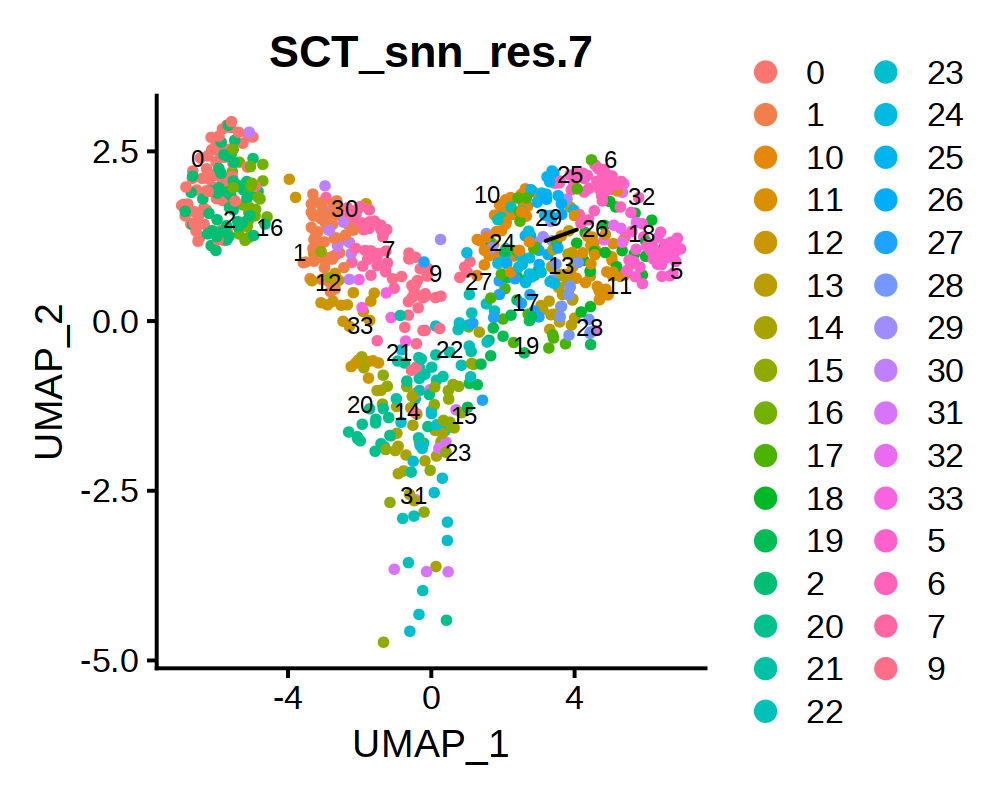

In [22]:
options(repr.plot.width=5,repr.plot.height=4,repr.plot.res=200)
esc.AS %>% subset(SCT_snn_res.7 %in% metadata_mc$mc_cluster) %>% DimPlot(reduction = "umap", group.by = "SCT_snn_res.7", label = TRUE, label.size = 3, repel = TRUE, pt.size = 1)

In [23]:
time <- metadata_mc %>% pull(time)

In [24]:
index_of_mc <- metadata_mc %>% as.data.frame %>% pull(mc_cluster) %>% unique()
for(i in index_of_mc){
    if(i==index_of_mc[1]){
        cellname_sel <- metadata %>% filter(mc_cluster == i) %>% pull(cellname)
        DI_dynamic_mc <- DI_dynamic[cellname_sel] %>% rowMeans() %>% as.data.frame %>% rownames_to_column("DI_pos")
        names(DI_dynamic_mc) <- c("DI_pos",paste0("mc_",i))
    }else{
        cellname_sel <- metadata %>% filter(mc_cluster == i) %>% pull(cellname)
        temp <- DI_dynamic[cellname_sel] %>% rowMeans() %>% as.data.frame %>% rownames_to_column("DI_pos")
        names(temp) <- c("DI_pos",paste0("mc_",i))
        DI_dynamic_mc <- left_join(DI_dynamic_mc, temp, by = "DI_pos")
    }
}

In [25]:
dim(DI_dynamic_mc)

[1] 188991     32

In [26]:
DI_dynamic_mc <- DI_dynamic_mc %>% column_to_rownames("DI_pos")
DI_dynamic_mc_norm <- scale(t(DI_dynamic_mc))
DI_dynamic_mc_norm <- t(DI_dynamic_mc_norm) %>% as.data.frame()

In [27]:
calculate_half_time <- function(df, time, row_index,span = 4) {
    
    data_row <- as.numeric(df[row_index,])
    df_test <- data.frame(data = data_row, time = time)
    df_test <- df_test %>% filter(!is.na(data)) %>% filter(!is.infinite(data))

    full_fit <- loess(data ~ time,df_test,se = TRUE,span=span)
    predictions <- predict(full_fit, newdata = data.frame(time=seq(min(df_test$time),max(df_test$time),0.01)))
    df_fit <- data.frame(time = seq(min(df_test$time),max(df_test$time),0.01), value = predictions)
    half_max_min <- (max(predictions, na.rm=T)+min(predictions, na.rm=T)) / 2
    
    max_y <- max(predictions, na.rm=T)
    min_y <- min(predictions, na.rm=T)
    max_x <- df_fit %>% filter(value == max(value)) %>% pull(time)
    min_x <- df_fit %>% filter(value == min(value)) %>% pull(time)
    end_y <- df_fit %>% filter(time == max(df_fit$time)) %>% pull(value)
    start_y <- df_fit %>% filter(time == min(df_fit$time)) %>% pull(value)
    
    halftime <- df_fit %>% mutate(diff = abs(value-half_max_min)) %>% filter(time > max_x) %>% filter(time < min_x)
    if(nrow(halftime)==0){
        halftime <- -1
    }else{
        halftime <- halftime %>% filter(diff == min(diff)) %>% pull(time)
    }
    
    predictions_mc <- predict(full_fit, newdata = data.frame(time=df_test$time))
    predictions_mc <- predictions_mc %>% as.data.frame %>% rename("pred" = ".")
    predictions_mc$raw_value <- df_test$data
    RSS <- predictions_mc %>% mutate(temp = (pred-raw_value)^2) %>% pull(temp) %>% sum()
    sqrtRSS <- sqrt(RSS)

    diff_exp_obs <- predictions_mc %>% mutate(temp = (pred-raw_value)^2)
    Q1 <- quantile(diff_exp_obs$temp, 0.25)
    Q3 <- quantile(diff_exp_obs$temp, 0.75)
    IQR <- Q3 - Q1
    lower_bound <- Q1 - 3 * IQR
    upper_bound <- Q3 + 3 * IQR
    outliers <- diff_exp_obs$temp[diff_exp_obs$temp > upper_bound]
    outliers <- length(outliers)

    return(list(max_x = max_x,min_x = min_x, halftime = halftime, sqrtRSS = sqrtRSS, min_y = min_y, max_y = max_y,start_y = start_y, end_y = end_y, outlier = outliers))
}

In [28]:
plot_full_curve <- function(df, time, row_index,res,span = 4) {
    
    DI_index <- rownames(df)[row_index]
    data_row <- as.numeric(df[row_index,])
    df_test <- data.frame(data = data_row, time = time)
    df_test <- df_test %>% filter(!is.na(data)) %>% filter(!is.infinite(data))
    
    full_fit <- loess(data ~ time,df_test,se = TRUE,span=span)
    predictions <- predict(full_fit, newdata = data.frame(time=seq(min(df_test$time),max(df_test$time),0.01)))
    df_fit <- data.frame(time = seq(min(df_test$time),max(df_test$time),0.01), value = predictions)
    half_max_min <- (max(predictions, na.rm=T)+min(predictions, na.rm=T)) / 2
    
    max_x <- df_fit %>% filter(value == max(value)) %>% pull(time)
    min_x <- df_fit %>% filter(value == min(value)) %>% pull(time)
    
    halftime <- df_fit %>% mutate(diff = abs(value-half_max_min)) %>% filter(time > max_x) %>% filter(time < min_x)
    if(nrow(halftime)==0){
        halftime <- -1
    }else{
        halftime <- halftime %>% filter(diff == min(diff)) %>% pull(time)
    }
    
    p <- ggplot(data = df_test, aes(x = time, y = data)) +
         geom_point(color = "black", size = 0.35, shape = 21) +
         geom_line(data = df_fit, aes(x = time, y = value), color = "red", linewidth = 0.5) +
         geom_vline(aes(xintercept = halftime), color = "gray", linetype = 'longdash') +
         labs(x = "Pseudotime", y = "Scaled imputated contacts") +        
         annotate("text", x = 1.02*halftime, y = max(df_test$data)*0.9, label = round(halftime,2), hjust = 0, family = "Arial", size=3) +
         theme_classic() +
        theme(legend.position = "none",
            text = element_text(family="Arial", size=8),
            panel.border = element_rect(color='black',linewidth=0.35,fill=NA),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.line = element_line(color="black", linewidth = 0.2),
            axis.ticks = element_line(color="black", linewidth = 0.35),
            axis.text = element_text(color="black",size=8),
            legend.key = element_rect(colour = NA),
            legend.key.width = unit(0.4, "cm"),
            axis.title=element_text(color="black",size=8,face="plain"),
        )
    
    # ggsave(filename = paste0("./RNA_dynamic_v4/snn7/", gene,"_",res,".png"), plot = p,width = 2, height = 2, dpi = 200)

    return(p)
}


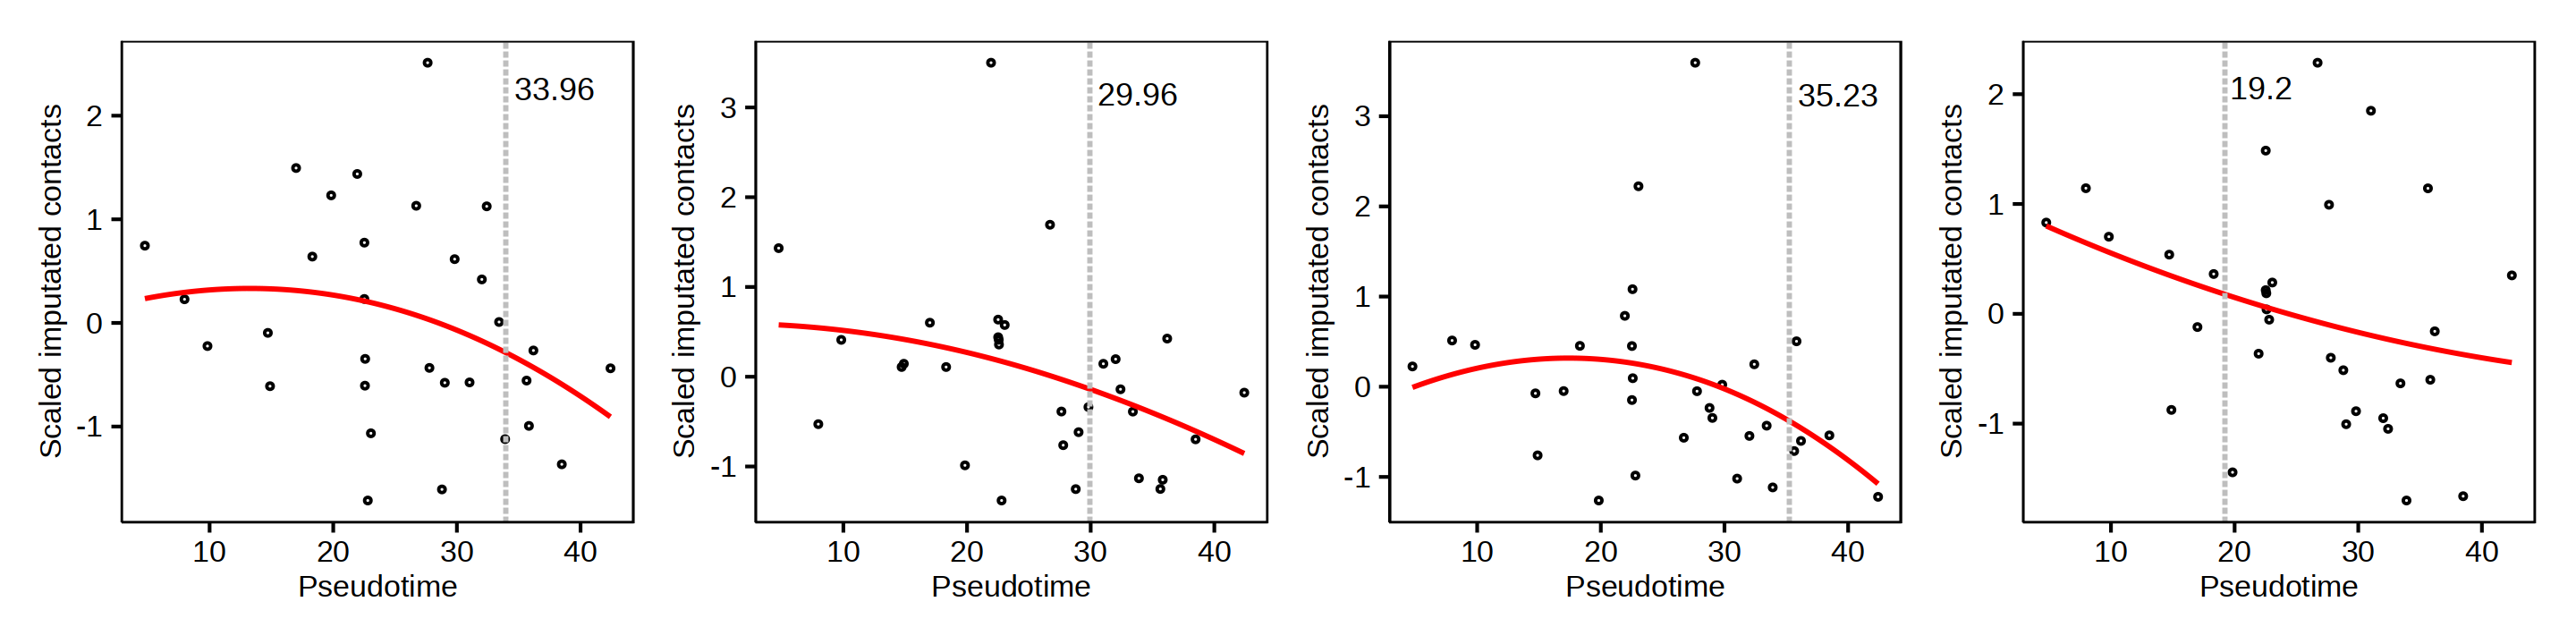

In [29]:
options(repr.plot.width=9.6,repr.plot.height=2.4,repr.plot.res=300)
plot_full_curve(DI_dynamic_mc_norm, time, 555, span = 4) | 
plot_full_curve(DI_dynamic_mc_norm, time, 888, span = 4)| 
plot_full_curve(DI_dynamic_mc_norm, time, 12345, span = 4) |
plot_full_curve(DI_dynamic_mc_norm, time, 20000, span = 4)

In [30]:
library(parallel)
numCores <- detectCores() - 10
cl <- makeCluster(numCores)
clusterExport(cl, c("calculate_half_time", "DI_dynamic_mc_norm", "time"))
clusterEvalQ(cl, library(dplyr))

[[1]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[8]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[9]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[10]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[11]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[12]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[13]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[14]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[15]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[16]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[17]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[18]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[19]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[20]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[21]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[22]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[23]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[24]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[25]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[26]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[27]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[28]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[29]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[30]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[31]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[32]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[33]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[34]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[35]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[36]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "m

In [31]:
halftimes <- c()
max_xs <- c()
min_xs <- c()
sqrtRSSs <- c()
min_ys <- c()
max_ys <- c()
start_ys <- c()
end_ys <- c()
outliers <- c()
# log2_DI_dynamic_mc <- log2(DI_dynamic_mc + 1)
N <- dim(DI_dynamic_mc)[1]

In [32]:
results <- parLapply(cl, seq_len(N), function(i) {
    result <- calculate_half_time(DI_dynamic_mc_norm, time, i)
    return(result)
})

# 关闭集群
stopCluster(cl)

# 从结果中提取数据
max_xs <- sapply(results, function(x) x$max_x)
min_xs <- sapply(results, function(x) x$min_x)
halftimes <- sapply(results, function(x) x$halftime)
sqrtRSSs <- sapply(results, function(x) x$sqrtRSS)
min_ys <- sapply(results, function(x) x$min_y)
max_ys <- sapply(results, function(x) x$max_y)
start_ys <- sapply(results, function(x) x$start_y)
end_ys <- sapply(results, function(x) x$end_y)
outliers <- sapply(results, function(x) x$outlier)

In [33]:
length(time)

[1] 31

In [34]:
DI_dynamic_mc_norm <- DI_dynamic_mc_norm %>% mutate(halftime = halftimes, sqrtRSS = sqrtRSSs, min_y = min_ys,max_y = max_ys, max_x = max_xs, min_x = min_xs,start_y = start_ys,end_y = end_ys, outlier = outliers)

In [35]:
selected$index_1D <- as.character(selected$index_1D)
selected <- selected %>% filter(index_1D %in% (DI_dynamic_mc_norm %>% rownames()))
heatmap_res <- selected %>% left_join(DI_dynamic_mc_norm %>% rownames_to_column("index_1D") %>% select(index_1D,halftime, sqrtRSS,max_x, min_x, max_y, min_y, start_y, end_y,outlier))
heatmap_res <- heatmap_res %>% as.data.frame
heatmap_res <- heatmap_res %>% arrange(halftime)

Joining with `by = join_by(index_1D)`


In [36]:
DI_dynamic_mc_norm <- DI_dynamic_mc_norm %>% select(-halftime, -sqrtRSS, -max_x, -min_x, -max_y, -min_y, -start_y, -end_y, -outlier)

# mc heatmap

In [10]:
heatmap_res <- read_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/halftime/DI_heatmap_res.csv')

Rows: 188082 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): temp
dbl (14): index1, index2, index_1D, stats, p_diff, halftime, sqrtRSS, max_x,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
dim(heatmap_res %>% filter(halftime != -1))[1]

[1] 180977

In [12]:
heatmap_res_filtered <- heatmap_res %>% filter(halftime != -1) %>% arrange(p_diff) %>% head(0.25*dim(heatmap_res %>% filter(halftime != -1))[1])
heatmap_res_filtered <- heatmap_res_filtered %>% arrange(sqrtRSS) %>% head(0.75*dim(heatmap_res_filtered)[1])
heatmap_res_filtered <- heatmap_res_filtered %>% arrange(halftime)
heatmap_res_filtered$index_1D <- as.character(heatmap_res_filtered$index_1D)

In [13]:
heatmap_res_filtered <- heatmap_res_filtered %>% mutate(dist = index2-index1)

In [14]:
# heatmap_res_filtered %>%  write_csv('DI_sqrtRSS_top50_heatmap.csv')

In [15]:
heatmap_res_filtered %>% pull(sqrtRSS) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.345   4.202   4.533   4.446   4.777   5.004 

In [37]:
plot_data <- DI_dynamic_mc_norm %>% filter(rownames(.) %in% (heatmap_res_filtered %>% pull(index_1D)))

In [43]:
metadata_mc <- metadata_mc %>% arrange(time) %>% mutate(mc = paste0("mc_",mc_cluster))

In [44]:
plot_data <- plot_data %>% select(metadata_mc %>% pull(mc))
plot_data <- plot_data[heatmap_res_filtered$index_1D,]

In [45]:
plot_data[plot_data >= 1.5] <- 1.5
plot_data[plot_data <= -1.5] <- -1.5

In [46]:
range_val <- range(plot_data, na.rm = TRUE)
range_val

[1] -1.5  1.5

In [47]:
library(circlize)
range_val <- range(plot_data, na.rm = TRUE)
breaks = c(-1.5, 0, 1.5)
color_func = colorRamp2(breaks, c("#92c5de","#ffffff","#f4a582"))
color_func_halftime = colorRamp2(c(10,25,28,32,36), c('#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494'))

In [49]:
rowAnno <- HeatmapAnnotation(df = metadata_mc %>% as.data.frame %>% select(plot_cluster) %>% mutate(plot_cluster = paste0("c",plot_cluster)),
                         col = list(plot_cluster = c('c0' = '#8dd3c7','c1' = '#ffffb3','c2' = '#bebada','c3' = '#fb8072','c4' = '#80b1d3','c5' = '#fdb462')),
                         simple_anno_size = unit(0.3, "cm"),
                         which = "row", show_annotation_name = FALSE,show_legend = c(FALSE))

In [50]:
topAnno <- HeatmapAnnotation(df = data.frame(heatmap_res_filtered) %>% select(halftime),
                             col = list(halftime = color_func_halftime), show_annotation_name = c(bar = FALSE),
                             simple_anno_size = unit(0.3, "cm"),
                             annotation_legend_param = list(
                               direction = "horizontal",  # 设置图例为水平方向
                               title = "Half time",  # 图例标题
                               labels_gp = gpar(fontsize = 6),  # 图例标签的字体设置
                               title_gp = gpar(fontsize = 6),
                               grid_height = unit(0.2, "cm"),
                               legend_width = unit(2.5, "cm"),
                               title_position = "topcenter"
                             ))

In [51]:
heatmap_res_filtered %>% pull(halftime) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.30   28.79   32.77   30.98   34.50   36.95 

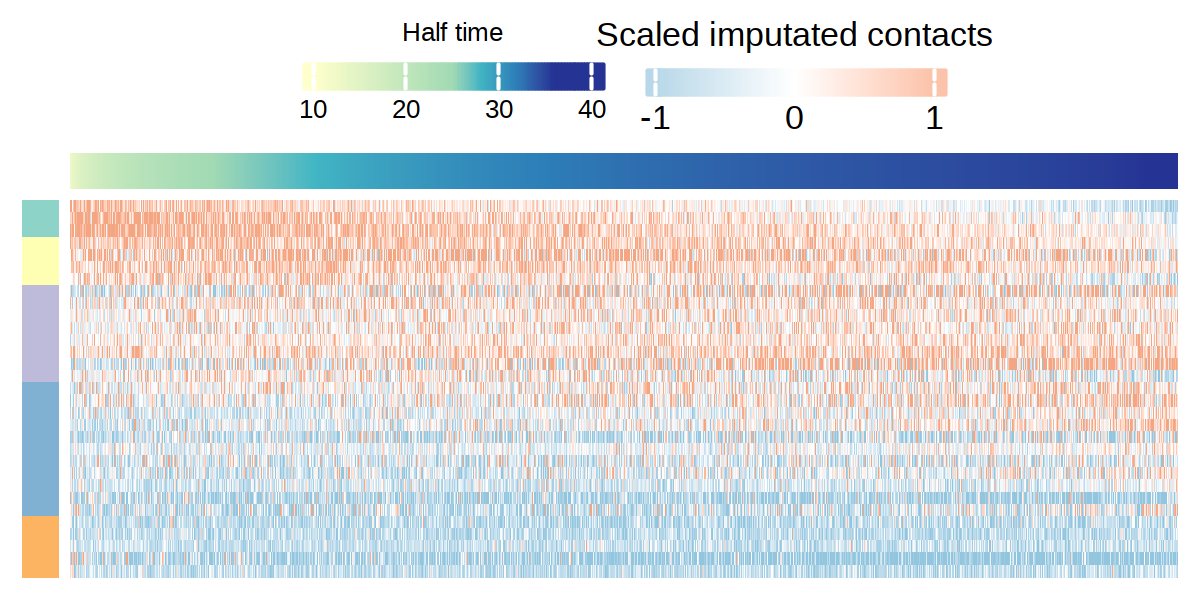

In [52]:
# png("/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/fig3/figures/fig3H.png", width = 4.8*300, height = 2.6*300, units = "px", res = 300)
options(repr.plot.width=4,repr.plot.height=2,repr.plot.res=300)
set.seed(42)
hm <- Heatmap(t(plot_data), 
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        col = color_func,
        show_row_names = FALSE, 
        show_column_names = FALSE,
        use_raster=FALSE,
        heatmap_legend_param = list(direction = "horizontal", at = c(-1,0,1), title = "Scaled imputated contacts",
                                    grid_height = unit(0.2, "cm"),labels_gp = gpar(fontsize = 8),title_gp = gpar(fontsize = 8),legend_width = unit(2.5, "cm"),title_position = "topcenter"),
        top_annotation= topAnno, 
        left_annotation = rowAnno, 
        border = FALSE,
        )
hm <- draw(hm, merge_legend = TRUE,heatmap_legend_side = "top", annotation_legend_side = "top",legend_gap = unit(1, "cm"))

hm

# dev.off()

# Different type

In [53]:
heatmap_res_filtered %>% pull(halftime) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.30   28.79   32.77   30.98   34.50   36.95 

In [54]:
heatmap_res_filtered <- heatmap_res_filtered %>% mutate(DI_dynamic_type = ifelse(halftime <= 28.79, 'Early', ifelse(halftime <= 34.50, 'Mid', 'Late'))) %>% mutate(DI_dynamic_type = factor(DI_dynamic_type, levels = c('Early','Mid','Late')))

In [56]:
heatmap_res_filtered %>% dim()

[1] 33933    19

In [101]:
pdf("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig4/fig4A_halftime_heatmap_day.pdf", width = 4.4, height = 2.2)

# 设置绘图参数
options(repr.plot.width=4.4, repr.plot.height=2.2, repr.plot.res=300)
set.seed(42)

# 绘制热图
hm <- Heatmap(t(plot_data), 
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        col = color_func,
        show_row_names = FALSE, 
        show_column_names = FALSE,
        use_raster=FALSE,
        heatmap_legend_param = list(direction = "horizontal", at = c(-1,0,1), title = "Scaled imputated contacts",
                                    grid_height = unit(0.2, "cm"), labels_gp = gpar(fontsize = 6), title_gp = gpar(fontsize = 6), legend_width = unit(2.5, "cm"), title_position = "topcenter"),
        top_annotation= topAnno, 
        left_annotation = rowAnno, 
        border = FALSE,
        column_split = heatmap_res_filtered$DI_dynamic_type,
        column_title=NULL
        )
hm <- draw(hm, merge_legend = TRUE, heatmap_legend_side = "top", annotation_legend_side = "top", legend_gap = unit(1, "cm"))
hm
# 关闭设备
dev.off()

png 
  2

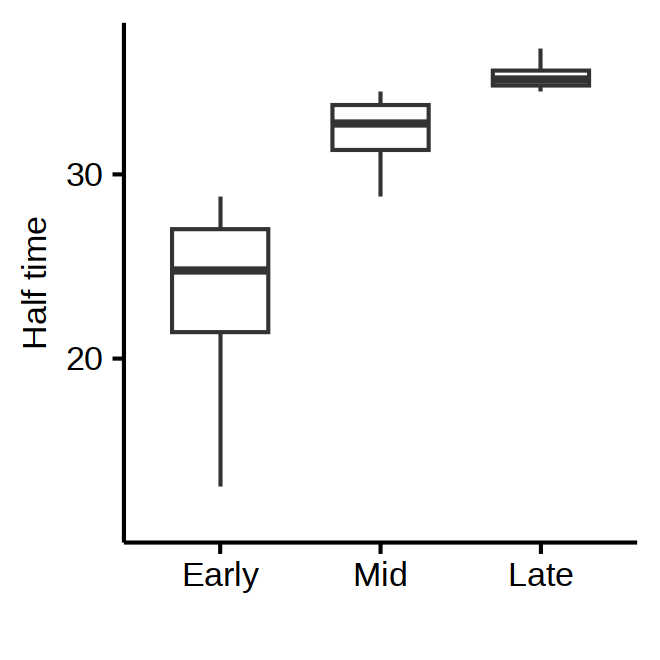

In [58]:
options(repr.plot.width=2.2,repr.plot.height=2.2,repr.plot.res=300)
heatmap_res_filtered %>% mutate(DI_dynamic_type = factor(DI_dynamic_type, levels = c("Early","Mid","Late"))) %>% 
    ggplot(aes(x = DI_dynamic_type,y = halftime),na.rm = TRUE) +
    geom_boxplot(outlier.shape = NA, width = 0.6, linewidth = 0.35) +
    ylab("Half time") + xlab("") + theme_classic() +
                    theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 

# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig4/fig4B_early_mid_late_boxplot.svg", width = 2.2, height = 2.2, units = "in", dpi = 300)

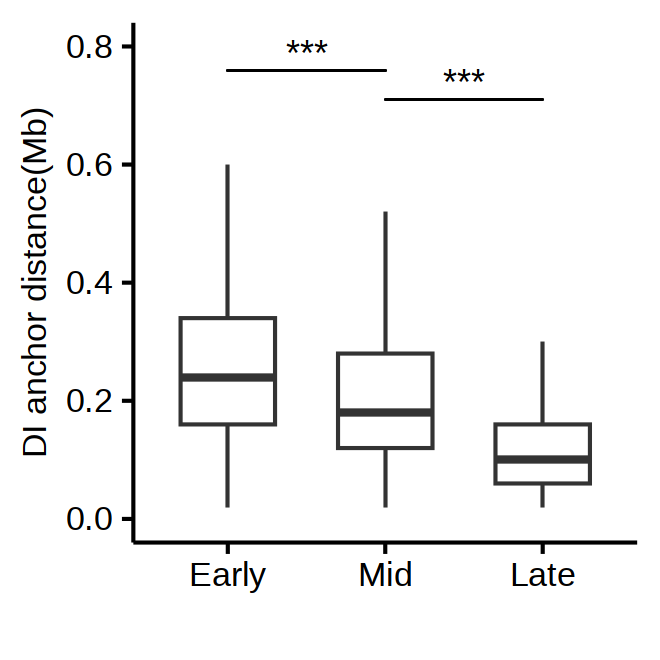

In [59]:
heatmap_res_filtered %>% mutate(dist_diagnal = (index2 - index1)*20000/1000000) %>% mutate(DI_dynamic_type = factor(DI_dynamic_type, levels = c("Early","Mid","Late"))) %>% 
    ggplot(aes(x = DI_dynamic_type,y = dist_diagnal),na.rm = TRUE) +
    geom_boxplot(outlier.shape = NA, width = 0.6, linewidth = 0.35) +
    ylab("DI anchor distance(Mb)") + xlab("") + theme_classic() + coord_cartesian(ylim = c(0, 0.8)) + 
    geom_signif(test = "t.test",comparisons = list(c("Early","Mid"), c("Mid","Late")), map_signif_level = TRUE, y_position = c(0.65, 0.6), textsize = 3, tip_length=0, size = 0.25)+
    theme_classic() +
                        theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 

# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig4/fig4F_DI_anchor_distance.svg", width = 2.2, height = 2.2, units = "in", dpi = 300)

In [60]:
my_tad %>% pull(distance) %>% median()

[1] 38.5

In [61]:
38.5*20000/1000000

[1] 0.77

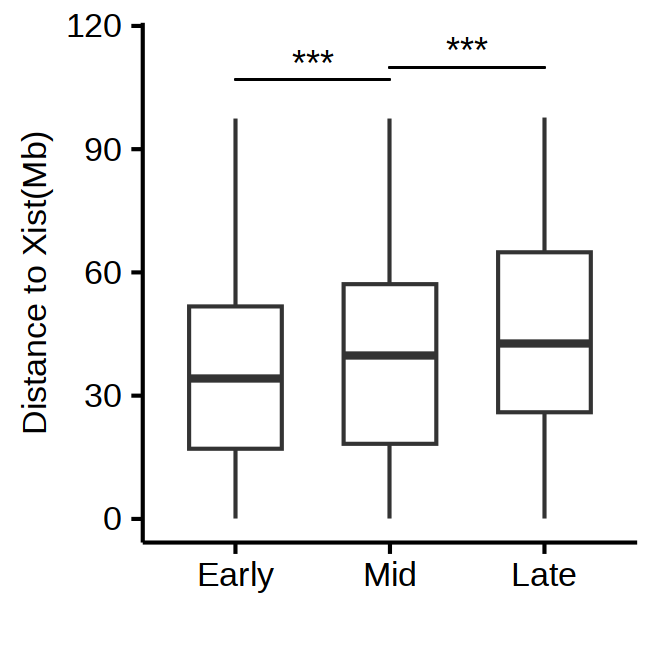

In [62]:
heatmap_res_filtered %>% mutate(min_anchor = ifelse(abs(index1-5173)<abs(index2-5173), index1, index2)) %>% mutate(dist_Xist = abs(min_anchor-5173)*20000/1000000) %>%
mutate(DI_dynamic_type = factor(DI_dynamic_type, levels = c("Early","Mid","Late"))) %>% 
    ggplot(aes(x = DI_dynamic_type,y = dist_Xist),na.rm = TRUE) +
    geom_boxplot(outlier.shape = NA, width = 0.6, linewidth = 0.35) +
    ylab("Distance to Xist(Mb)") + xlab("") + theme_classic() +
    geom_signif(test = "t.test",comparisons = list(c("Early","Mid"), c("Mid","Late")), map_signif_level = TRUE,y_position = c(102,105), textsize = 3, tip_length=0, size = 0.25) +
    coord_cartesian(ylim = c(0, 115)) +
                        theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 
# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig4/fig4C_DI_distance_Xist.svg", width = 2.2, height = 2.2, units = "in", dpi = 300)


New names:
• `` -> `...1`
Rows: 25778 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chrom
dbl (7): ...1, start, end, weight, E1, E2, E3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


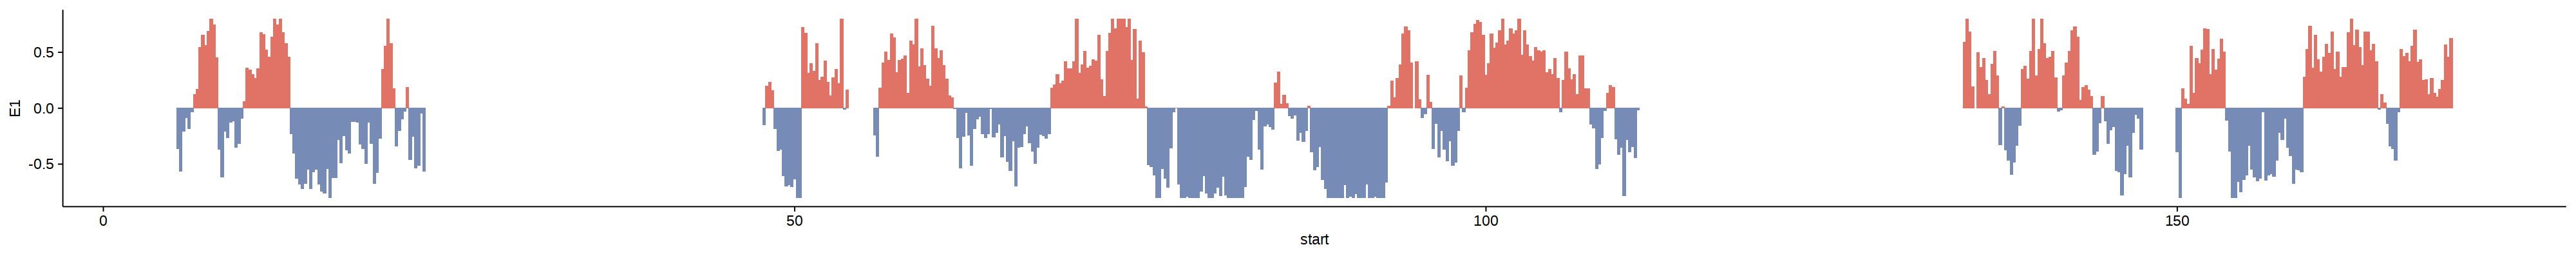

In [63]:
# file_paths = "/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/HiC_analysis/compartment/cooltools_compartment/B6Xi100k_c5.cis.vecs.tsv"
options(repr.plot.width=20,repr.plot.height=2,repr.plot.res=200)

file_paths = "/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/fig2/compartment/c5_200000.cis.vecs.tsv"

read_wrapper <- function(filepath) {
    read_tsv(filepath) %>% mutate(file = filepath)
}
list_of_dataframes = lapply(file_paths, read_wrapper)
compartments = bind_rows(list_of_dataframes) %>% na.omit()

compartments <- compartments %>% filter(chrom == "chrX(pat)") %>% select(start, end, E1) %>% mutate(compartment = ifelse(E1 >= 0, "A","B"))

compartments %>% mutate(compartment = ifelse(E1> 0, "A","B")) %>% 
        na.omit() %>%  mutate(E1 = ifelse(E1>0.8,0.8,E1), E1 = ifelse(E1<(-0.8),-0.8,E1)) %>% mutate(start = start/1000000) %>% 
        ggplot()  +
        geom_col(aes(x=start,y=E1,fill = compartment), width = 0.2, size = 0.25) + scale_fill_manual(values=c("#e07266","#768cb6"), name = 'Compartment') + 
          theme(legend.position = "none",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.25),
  axis.ticks = element_line(color="black", linewidth = 0.25),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 

In [64]:
early_site <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/halftime/early_sites.csv")
names(early_site) <- c('index','value')

New names:
• `` -> `...1`
Rows: 1711 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): ...1, 0

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [65]:
heatmap_res_filtered %>% select(index1, halftime) %>% rename(index = index1) %>% 
    rbind(heatmap_res_filtered %>% select(index2, halftime) %>% rename(index = index2)) %>% mutate(index = floor(index*20000/100000)) %>% 
    group_by(index) %>% summarise(median = median(halftime)) -> median_halftime_100k

In [66]:
heatmap_res_filtered %>% select(index1, halftime) %>% rename(index = index1) %>% 
    rbind(heatmap_res_filtered %>% select(index2, halftime) %>% rename(index = index2)) %>% mutate(index = floor(index*20000/100000)) %>% 
    group_by(index) %>% summarise(mean = mean(halftime)) -> mean_halftime_100k

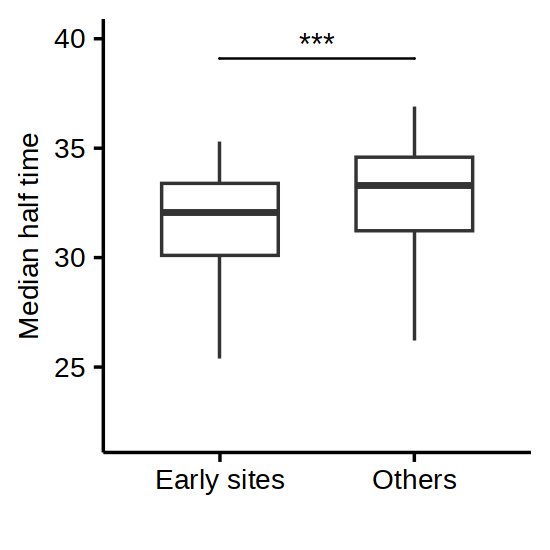

In [67]:
options(repr.plot.width=2.2,repr.plot.height=2.2,repr.plot.res=250)

median_halftime_100k %>% 
    mutate(type = ifelse(index %in% (early_site %>% filter(value > 1.2) %>% pull(index)), 'Early sites', 'Others')) %>% mutate(type = factor(type, levels = c('Early sites','Others'))) %>%
    mutate(index = index*100000/1000000) %>%  
    ggplot(aes(x = type,y = median)) + 
    geom_boxplot(outlier.shape = NA, width = 0.6, linewidth = 0.35, position = position_dodge(0.75)) +
    coord_cartesian(ylim = c(22, 40))+xlab('') +
    geom_signif(test = "t.test",comparisons = list(c("Others","Early sites")), map_signif_level = TRUE, y_position = c(38), textsize = 3, tip_length=0, size = 0.25) + 
    ylab('Median half time') + theme_classic() +
                theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 
    
# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig4/fig4E_Xist_early_binding.svg", width = 2.2, height = 2.2, units = "in", dpi = 300)


Joining with `by = join_by(index1_200k)`
Joining with `by = join_by(index2_200k)`


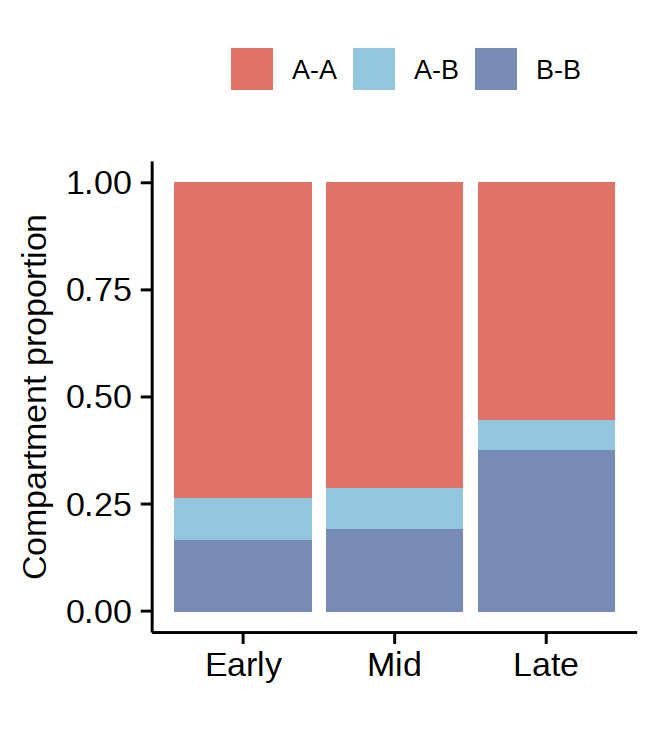

In [68]:
options(repr.plot.width=2.2,repr.plot.height=2.5,repr.plot.res=300)

heatmap_res_filtered %>% mutate(index1_200k = floor(index1*20000/200000), index2_200k = floor(index2*20000/200000)) %>% 
    select(index1_200k, index2_200k, halftime, DI_dynamic_type) %>% left_join(compartments %>% mutate(index = start/200000) %>% select(index, E1) %>% rename(index1_200k=index)) %>% 
    rename(comp_index1=E1) %>% left_join(compartments %>% mutate(index = start/200000) %>% select(index, E1) %>% rename(index2_200k=index)) %>% rename(comp_index2=E1) %>% 
    mutate(contact = ifelse(comp_index1>0 & comp_index2 >0, 'A-A',
                     ifelse(comp_index1<0 & comp_index2 <0, 'B-B','A-B'))) %>% 
    filter(!is.na(contact)) %>%
    mutate(DI_dynamic_type = factor(DI_dynamic_type, levels=c('Early','Mid','Late'))) %>%
    ggplot(aes(x=DI_dynamic_type, fill=contact)) + 
    geom_bar(position = position_fill(), width = 0.9) + theme_classic() + xlab('') + ylab('Compartment proportion') + scale_fill_manual(values = c('#e07266','#92c5de','#768cb6'), name = '') +
            theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.25),
  axis.ticks = element_line(color="black", linewidth = 0.25),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 

# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig4/fig4D_comp_proportion.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)


In [38]:
my_tad <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/new_version/my_tad_filtered_mod_tadE_new.csv")

New names:
• `` -> `...1`
Rows: 112 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (6): ...1, index, start, end, distance, mask

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [39]:
tad_location <- data.frame()
for (i in 1:nrow(my_tad)){
    start_bin <- my_tad$start[i]
    end_bin <- my_tad$end[i]
    index <- my_tad$index[i]
    temp <- heatmap_res %>% mutate(tad_loc = ifelse(((index1 == start_bin)&(index2 == end_bin)),'loop',
                                                          ifelse(((index1 >= start_bin)&(index1 < end_bin)&(index2 >= start_bin)&(index2 < end_bin)), 'intra','outside')))
    temp <- temp %>% filter(tad_loc != 'outside') %>% mutate(tad_index = index)
    if(i == 1){
        tad_location <- temp
    }else{
        tad_location <- rbind(tad_location, temp)
    }
}

In [40]:
tad_loc_stat <- tad_location %>% filter(index_1D %in% (heatmap_res_filtered %>% pull(index_1D)))

In [41]:
tad_location2 <- data.frame()
for (i in 1:nrow(my_tad)){
    start_bin <- my_tad$start[i]
    end_bin <- my_tad$end[i]
    index <- my_tad$index[i]

    size <- end_bin-start_bin+1
    r0 <- size*0.25
    
    temp <- tad_loc_stat %>% filter(tad_index == index)
    temp <- temp %>% mutate(r0 = r0) %>% mutate(r = sqrt((index1-start_bin)**2+(index2-end_bin)**2))
    temp <- temp %>% mutate(tad_loc2 = ifelse(r<=r0,'anchor','intra'))
    
    if(i == 1){
        tad_location2 <- temp
    }else{
        tad_location2 <- rbind(tad_location2, temp)
    }
}

In [42]:
sel_tad <- tad_location2 %>% group_by(tad_index,tad_loc2) %>% summarise(count = n()) %>%
    group_by(tad_index) %>% summarise(count = n()) %>% filter(count == 2) %>% pull(tad_index)

`summarise()` has grouped output by 'tad_index'. You can override using the
`.groups` argument.


In [43]:
sel_tad <- sel_tad %>% intersect(my_tad %>% filter(distance <= 100) %>% pull(index))

In [44]:
sel_tad

[1]   1   2   3   4   5   9  23  24  25  31  33  34  35  36  37  43  44  45  47
[20]  50  51  58  59  64  65  66  68  69  70  71  72  73  75  77  78  79 100 101
[39] 103 104 105 109 113 115 116 117 119 120 121 123 124 126 127 132

In [45]:
sel_tad %>% length()

[1] 54

`summarise()` has grouped output by 'tad_index'. You can override using the
`.groups` argument.


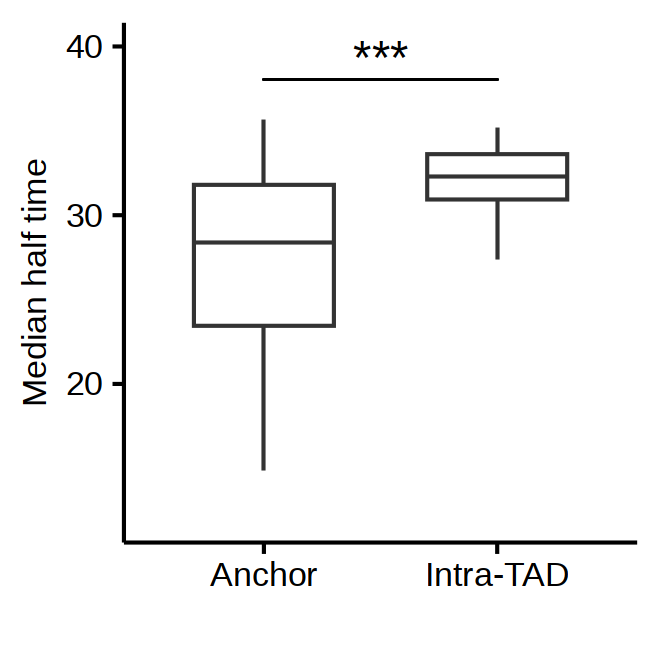

In [46]:
options(repr.plot.width=2.2,repr.plot.height=2.2,repr.plot.res=300)

tad_location2 %>% filter(tad_index %in% sel_tad) %>% group_by(tad_index, tad_loc2) %>% 
    summarise(median_halftime = median(halftime)) %>% 
    ggplot(aes(x = tad_loc2,y = median_halftime),na.rm = TRUE) + 
    geom_boxplot(fatten = 1, outlier.shape = NA, width = 0.6, linewidth = 0.35) +
    geom_signif(comparisons = list(c("anchor", "intra")), 
              tip_length=0, size = 0.25, map_signif_level = TRUE, y_position = 37,
              test = "t.test", test.args = list(paired = TRUE)) + xlab('') + ylab('Median half time') +
    scale_x_discrete(labels = c('Anchor','Intra-TAD'))+ coord_cartesian(ylim = c(12, 40)) + theme_classic() +
                theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 
# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig4/fig4G_TAD_anchor_intra_halftime.svg", width = 2.2, height = 2.2, units = "in", dpi = 300)

# plot curve

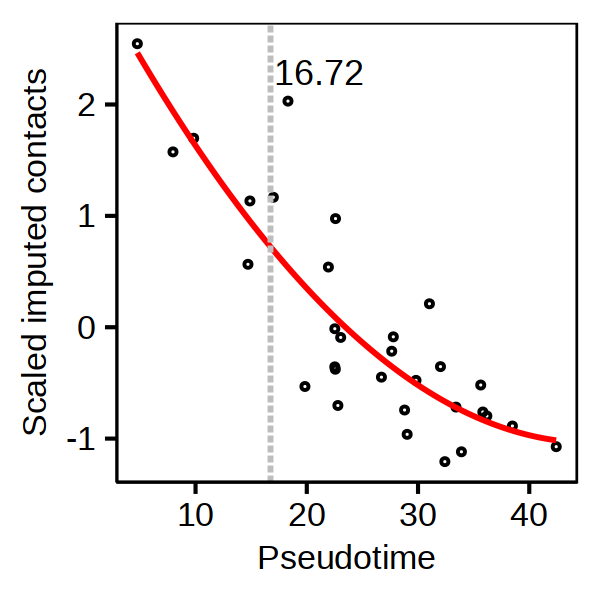

In [175]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)
p1 <- plot_full_curve(DI_dynamic_mc_norm, time, '96418', span = 4) + xlab("Pseudotime") + ylab("Scaled imputed contacts") 
p1

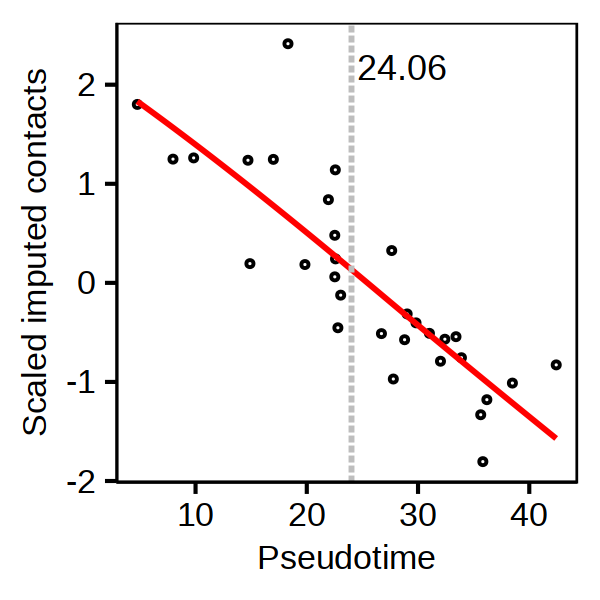

In [176]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)
p2 <- plot_full_curve(DI_dynamic_mc_norm, time, '68762', span = 4) + xlab("Pseudotime") + ylab("Scaled imputed contacts") 
p2

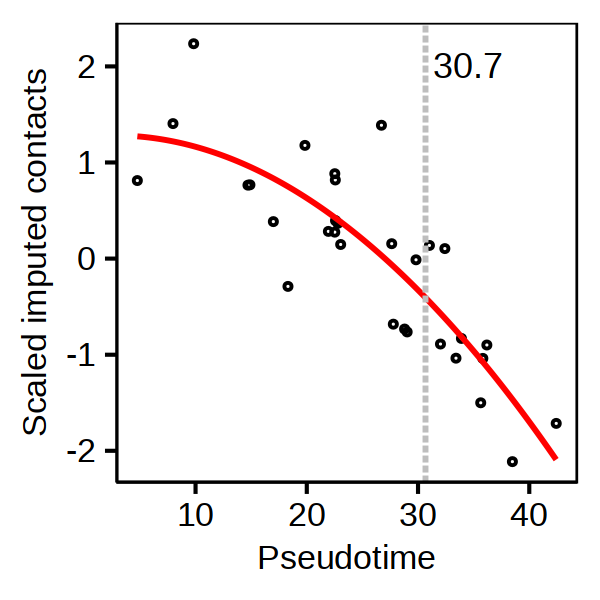

In [177]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)
p3 <- plot_full_curve(DI_dynamic_mc_norm, time, '76742', span = 4) + xlab("Pseudotime") + ylab("Scaled imputed contacts") 
p3